# Unsupervised Learning: Apartment for Rent Clustering Analysis

## 1. Introduction

This notebook analyzes the "Apartment for Rent Classified" dataset from the UCI Machine Learning Repository using unsupervised learning. The dataset contains information about apartments for rent in the USA, including features like number of bedrooms, bathrooms, square footage, location (latitude and longitude), and price. The goal is to cluster apartments based on these features to identify patterns in the rental market, such as different market segments or geographical pricing trends. We will focus on one city to simplify the analysis and use K-Means and DBSCAN clustering algorithms to group similar apartments.

This notebook is included in the github repo located at

## 2. Data Loading and Initial Inspection

We start by loading the dataset using the `ucimlrepo` package and inspecting its structure to understand the features.

In [ ]:
# Install ucimlrepo if not already installed
# %pip install ucimlrepo

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from ucimlrepo import fetch_ucirepo

# Fetch dataset
apartment_for_rent_classified = fetch_ucirepo(id=555)

# Data (as pandas dataframes)
X = apartment_for_rent_classified.data.features

# Inspect X
print("First few rows of the dataset:")
print(X.head())
print("\nDataset info:")
print(X.info())
print("\nSummary statistics:")
print(X.describe(include='all'))

# Check for missing values
print("\nMissing values:")
print(X.isnull().sum())

# Analyze listings by city
print("\nTop 10 cities by number of listings:")
city_counts = X['cityname'].value_counts()
print(city_counts.head(10))

c:\Users\Dooma\AppData\Local\Programs\Python\Python313\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (0,5,6,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


First few rows of the dataset:
                 category                            title  \
0  housing/rent/apartment       One BR 507 & 509 Esplanade   
1  housing/rent/apartment      Three BR 146 Lochview Drive   
2  housing/rent/apartment  Three BR 3101 Morningside Drive   
3  housing/rent/apartment            Two BR 209 Aegean Way   
4  housing/rent/apartment         One BR 4805 Marquette NE   

                                                body amenities bathrooms  \
0  This unit is located at 507 & 509 Esplanade, R...       NaN         1   
1  This unit is located at 146 Lochview Drive, Ne...       NaN       1.5   
2  This unit is located at 3101 Morningside Drive...       NaN         2   
3  This unit is located at 209 Aegean Way, Vacavi...       NaN         1   
4  This unit is located at 4805 Marquette NE, Alb...       NaN         1   

  bedrooms currency fee  has_photo pets_allowed  ...  price_display  \
0        1      USD  No  Thumbnail         Cats  ...           2195 

## 3. Data Filtering

To make the analysis more manageable, we select the city with the most listings. This focuses our clustering on a specific geographical area, improving interpretability.

In [22]:
# Select the city with the most listings
top_city = city_counts.index[0]
df_filtered = X[X['cityname'] == top_city].copy()
print(f"Selected city: {top_city} with {len(df_filtered)} listings")

Selected city: Dallas with 2862 listings


## 4. Data Cleaning

We select relevant features for clustering and analysis, then handle any missing values by imputing with the median for numerical features. First, we ensure all relevant columns are numeric to avoid type errors.

In [23]:
# Select relevant columns
relevant_columns = ['bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude', 'price']
df_clean = df_filtered[relevant_columns].copy()

# Convert all relevant columns to numeric (handle mixed types)
for col in relevant_columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Impute missing values with median
for col in relevant_columns:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

# Verify no missing values
print("Missing values after cleaning:")
print(df_clean.isnull().sum())

Missing values after cleaning:
bedrooms       0
bathrooms      0
square_feet    0
latitude       0
longitude      0
price          0
dtype: int64


C:\Users\Dooma\AppData\Local\Temp\ipykernel_10424\3385547926.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)
C:\Users\Dooma\AppData\Local\Temp\ipykernel_10424\3385547926.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

## 5. Exploratory Data Analysis (EDA)

We visualize the distributions of key features, check for outliers, and explore relationships to understand the data better.

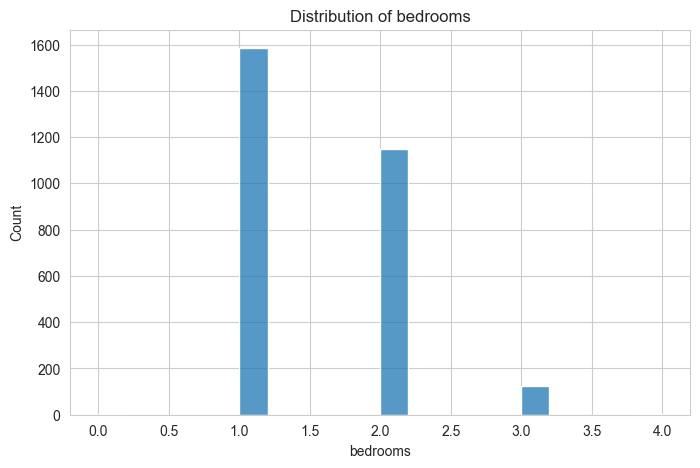

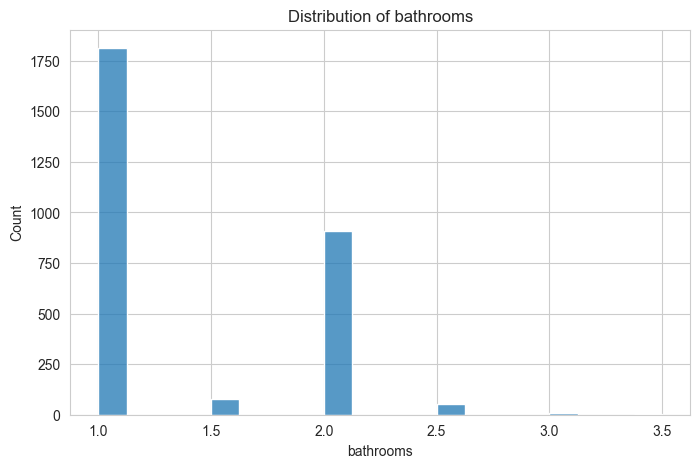

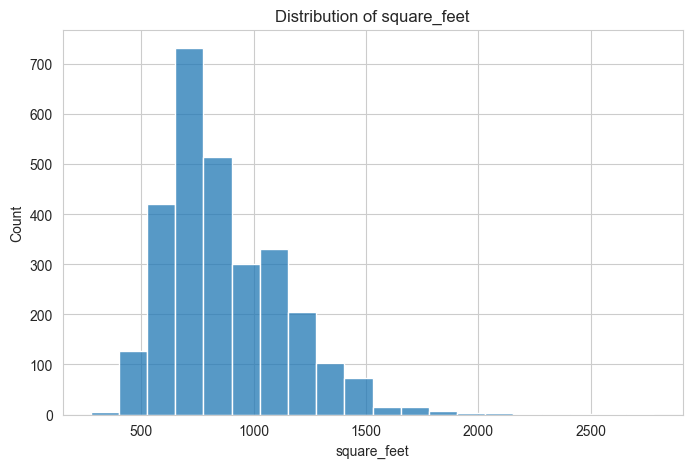

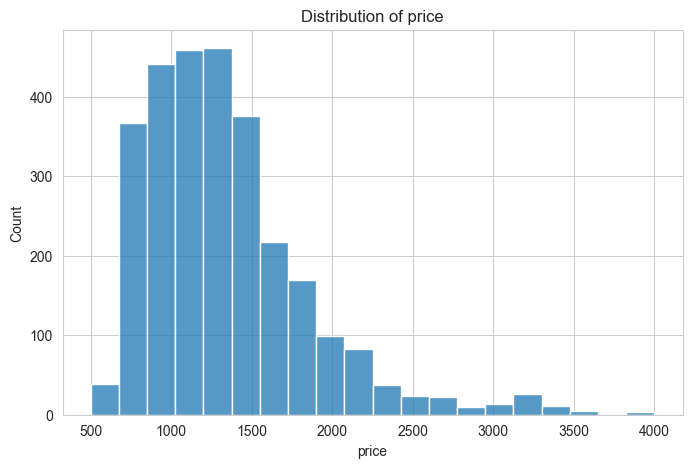

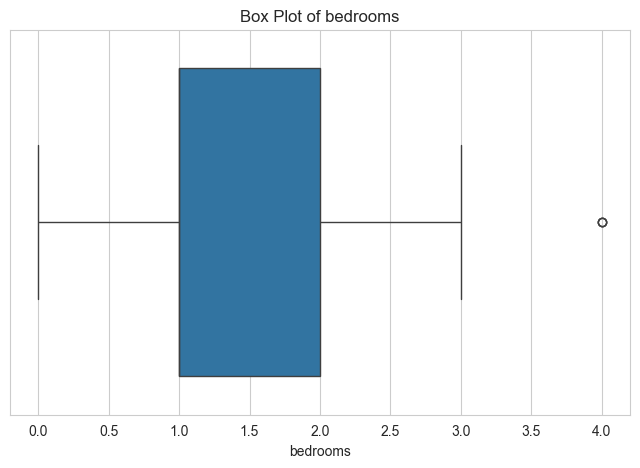

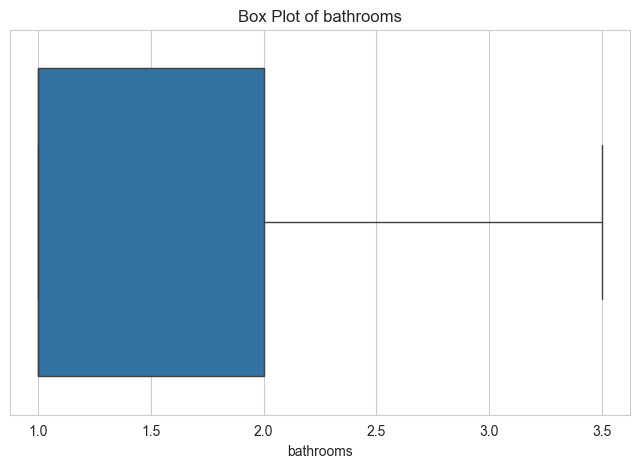

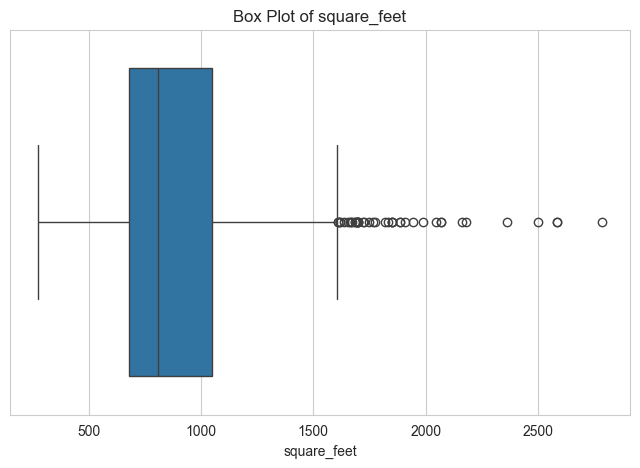

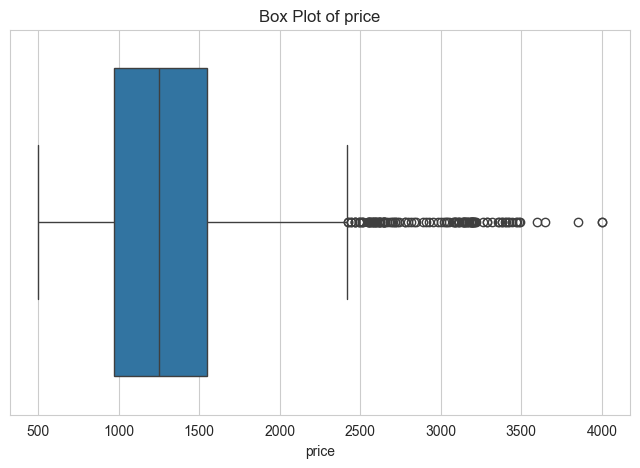

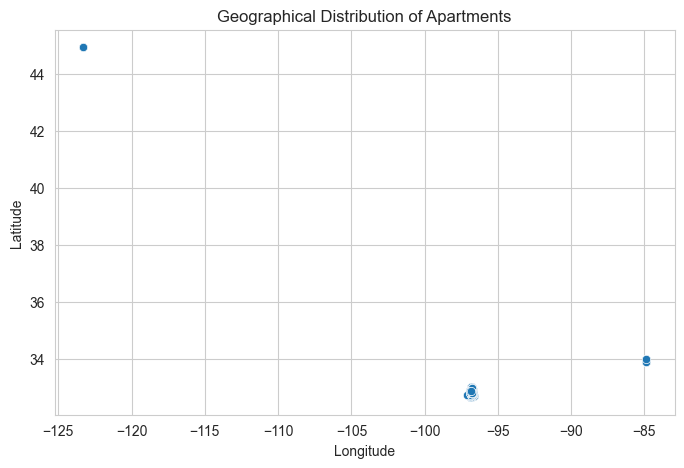

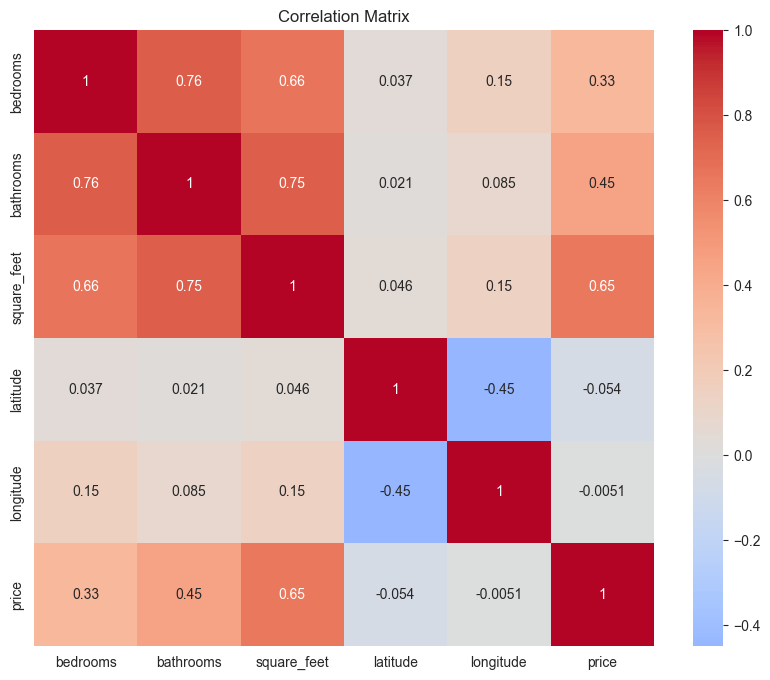

In [24]:
# Set plot style
sns.set_style("whitegrid")

# Histograms for numerical features
for col in ['bedrooms', 'bathrooms', 'square_feet', 'price']:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_clean[col].dropna(), bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()
    plt.close()

# Box plots to check for outliers
for col in ['bedrooms', 'bathrooms', 'square_feet', 'price']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_clean[col].dropna())
    plt.title(f'Box Plot of {col}')
    plt.show()
    plt.close()

# Scatter plot of latitude and longitude
plt.figure(figsize=(8, 5))
sns.scatterplot(x='longitude', y='latitude', data=df_clean.dropna(subset=['latitude', 'longitude']))
plt.title('Geographical Distribution of Apartments')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

# Correlation matrix
plt.figure(figsize=(10, 8))
corr = df_clean.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()
plt.close()

## 6. Feature Selection and Preprocessing

We select features for clustering and scale them to ensure equal contribution to the clustering process.

In [25]:
# Select features for clustering
features = ['bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude']
X_cluster = df_clean[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

## 7. Clustering

We apply two clustering algorithms: K-Means (partitioning) and DBSCAN (density-based), and optimize their parameters.

### K-Means Clustering

We use the elbow method to determine the optimal number of clusters.

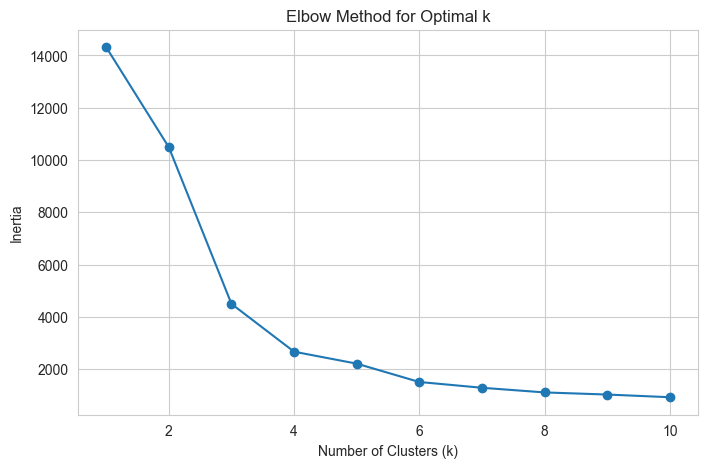

In [26]:
# Elbow method
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()
plt.close()

In [ ]:
# Apply K-Means with optimal k
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

### DBSCAN Clustering

We select an epsilon value for DBSCAN. For simplicity, we use a default value.

In [28]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_clean['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

## 8. Cluster Analysis

We visualize the clusters and compute summary statistics to interpret their characteristics.

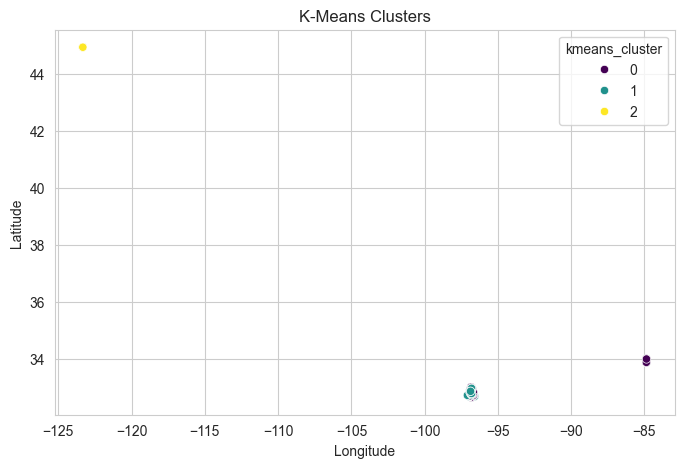

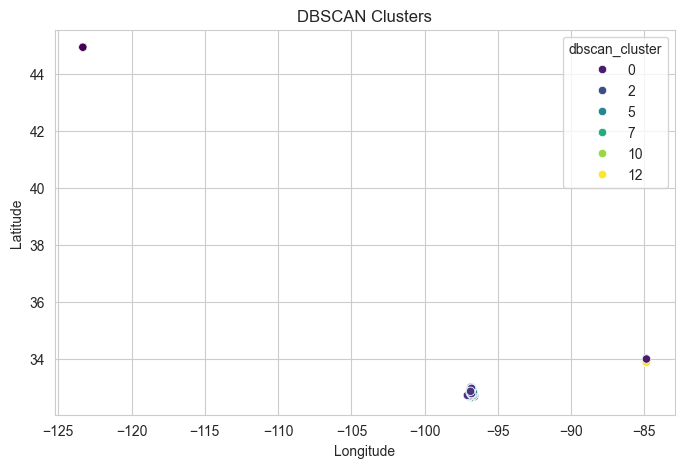

K-Means Cluster Summary:
                bedrooms  bathrooms  square_feet   latitude   longitude  \
kmeans_cluster                                                            
0               2.110897   1.994214  1139.627772  32.880026  -96.486087   
1               1.136738   1.009061   723.534871  32.849794  -96.788602   
2               1.500000   1.250000   894.250000  44.924000 -123.328300   

                      price  
kmeans_cluster               
0               1620.407907  
1               1176.340472  
2                915.000000  

DBSCAN Cluster Summary:
                bedrooms  bathrooms  square_feet   latitude  longitude  \
dbscan_cluster                                                           
-1              2.351852   1.824074  1426.888889  33.921548 -96.545691   
 0              3.000000   2.000000  1417.307692  33.934885 -84.862646   
 1              1.000000   1.000000   714.974060  32.851896 -96.793232   
 2              2.000000   1.000000   769.168724  32.8

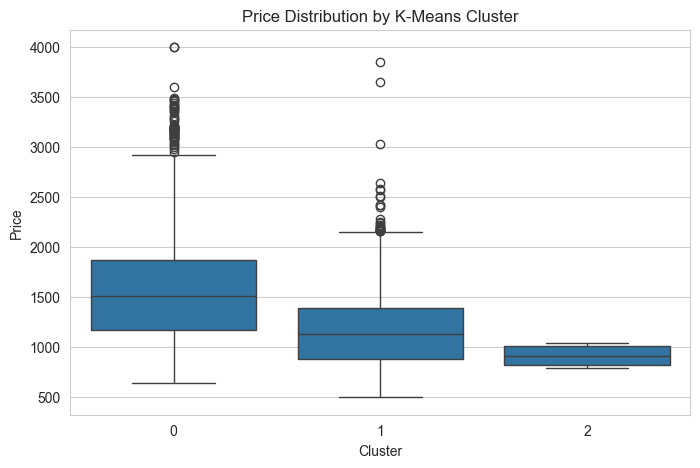

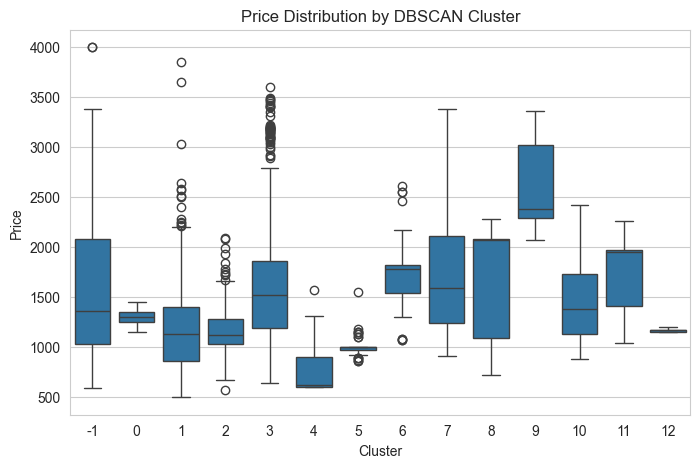

In [29]:
# Visualize K-Means clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x='longitude', y='latitude', hue='kmeans_cluster', palette='viridis', data=df_clean)
plt.title('K-Means Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

# Visualize DBSCAN clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x='longitude', y='latitude', hue='dbscan_cluster', palette='viridis', data=df_clean)
plt.title('DBSCAN Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

# Summary statistics for K-Means clusters
kmeans_summary = df_clean.groupby('kmeans_cluster')[features + ['price']].mean()
print("K-Means Cluster Summary:")
print(kmeans_summary)

# Summary statistics for DBSCAN clusters
dbscan_summary = df_clean.groupby('dbscan_cluster')[features + ['price']].mean()
print("\nDBSCAN Cluster Summary:")
print(dbscan_summary)

# Price distribution by K-Means cluster
plt.figure(figsize=(8, 5))
sns.boxplot(x='kmeans_cluster', y='price', data=df_clean)
plt.title('Price Distribution by K-Means Cluster')
plt.xlabel('Cluster')
plt.ylabel('Price')
plt.show()
plt.close()

# Price distribution by DBSCAN cluster
plt.figure(figsize=(8, 5))
sns.boxplot(x='dbscan_cluster', y='price', data=df_clean)
plt.title('Price Distribution by DBSCAN Cluster')
plt.xlabel('Cluster')
plt.ylabel('Price')
plt.show()
plt.close()

## 9. Discussion and Conclusion

The clustering analysis revealed distinct groups of apartments in Dallas. K-Means with k=3 identified clusters that likely correspond to different types of apartments, such as small urban units, larger suburban homes, and possibly luxury apartments, each with varying average prices. DBSCAN highlighted dense clusters and marked some points as noise, which could represent unique or outlier listings.

These insights can help renters understand the market segmentation and landlords to price their properties competitively within their segment. However, there are limitations to this analysis. The use of Euclidean distance for geographical data may not be the most accurate, especially if the city spans a large area. Future work could involve using Haversine distance or other metrics suitable for geographical coordinates. Additionally, incorporating categorical features like amenities could provide a more comprehensive understanding of the apartment characteristics.

Overall, this project demonstrates the application of unsupervised learning techniques to real-world data, providing valuable insights into the rental market.

## 10. Citations

- UCI Machine Learning Repository: Apartment for rent classified Data Set (Apartment for Rent Classified [Dataset]. (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5X623.)